In [104]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax.random import PRNGKey, split
from jax import config
config.update("jax_enable_x64", True)
from tqdm import tqdm

from data import generate_data, generate_orthogonal_input
from loss import create_loss
from network import init_net, compute_outputs, compute_factor
from solver import train
from utils import compose, svd, compute_angle, compute_svd_series
from plot import plot_sv_series

In [140]:
key = PRNGKey(0)

input_dim = 30
output_dim = 3
n_samples = 300
depth = 3
init_type = "orth"
init_scale = 1

key, subkey = split(key)
target = generate_data(key=subkey, shape=(output_dim, n_samples))

key, subkey = split(key)

input_data = generate_data(key=subkey, shape=(input_dim, n_samples)) / 15

# eps = (target_cond - 1) / (target_cond + 1)
# s = jnp.linspace(1-eps, 1+eps, num=input_dim)[::-1]
# input_data = U @ jnp.diag(s) @ V.T

key, subkey = split(key)
init_weights = init_net(
    key=subkey, 
    input_dim=input_dim, 
    output_dim=output_dim,
    width=input_dim,
    depth=depth,
    init_scale=init_scale
)

loss_fn = create_loss(target)

loss_fn_dict = {
    'train': loss_fn
}

network_fn = lambda w: compute_outputs(w, input_data, nonlinear=False)[0]

In [143]:
n_outer_loops = 50
step_size = 1
result = train(
    init_weights=init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    save_weights=True,
    n_inner_loops=1
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [144]:
series_list = []
series_list.append(compute_svd_series(result['weights'], 0, output_dim))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.38it/s]


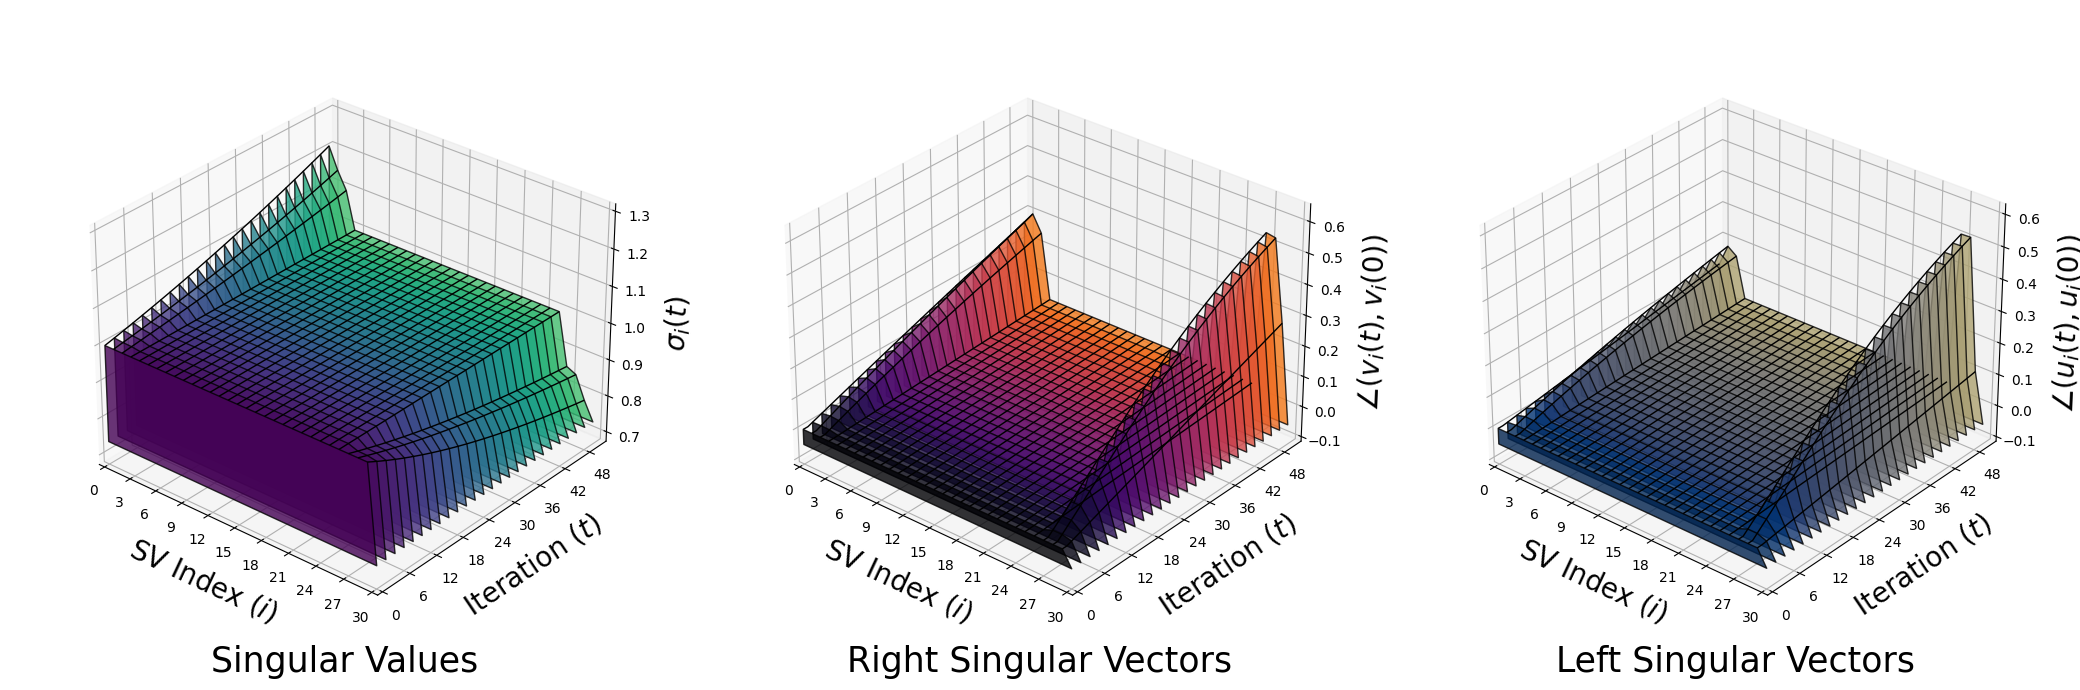

In [145]:
sval_series, right_series, left_series = series_list[0]

fig = plt.figure(figsize=(21, 7))
ax = fig.add_subplot(131, projection='3d')
plot_sv_series(ax, sval_series)

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n$\sigma_i(t)$', fontsize=20)

ax.set_title('Singular Values', fontsize=25, y=0.0)

ax = fig.add_subplot(132, projection='3d')

plot_sv_series(ax, right_series, color='inferno')

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n' + r'$\angle(v_i(t), v_i(0))$', fontsize=20)

ax.set_title('Right Singular Vectors', fontsize=25, y=0.0)

ax = fig.add_subplot(133, projection='3d')

plot_sv_series(ax, left_series, color='cividis')

ax.set_xlabel('\nSV Index ($i$)', fontsize=20)
ax.set_ylabel('\nIteration ($t$)', fontsize=20)
ax.set_zlabel('\n' + r'$\angle(u_i(t), u_i(0))$', fontsize=20)

ax.set_title('Left Singular Vectors', fontsize=25, y=0.0)

plt.tight_layout()
plt.savefig('figs/thm_nonwhitened.png', dpi=300, bbox_inches='tight')